# 分析地震目录

- 本节贡献者: {{田冬冬}}（作者）、{{姚家园}}（审稿）
- 最近更新日期: 2022-07-31
- 预计花费时间: 15 分钟

---

在获取地震目录之后，通常还需要对地震目录做一些简单的绘图和分析。这一节演示如何
绘制最简单的地震深度直方图、地震震级直方图以及震级-频次关系图。

首先，需要把地震目录准备好。这里我们选择下载 2000–2010 年间震级大于 4.8 级，
震源深度大于 50 km 的地震。这一地震目录中共计约 7000 个地震：

In [1]:
from obspy.clients.fdsn import Client

client = Client("USGS")
cat = client.get_events(
    starttime="2000-01-01",
    endtime="2010-01-01",
    minmagnitude=4.8,
    mindepth=50,
)
print(cat)

6980 Event(s) in Catalog:
2009-12-31T17:42:15.960000Z | -19.747, -177.753 | 5.4  mwc | manual
2009-12-31T09:06:01.250000Z |  -7.499, +127.930 | 5.1  mb | manual
...
2000-01-02T12:14:39.090000Z | -17.943, -178.476 | 5.5  mwc | manual
2000-01-01T05:24:35.290000Z | +36.874,  +69.947 | 5.1  mwc | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


为了进一步对数据做处理以及绘图，我们还需要导入 [NumPy](https://numpy.org/)
和 [Matplotlib](https://matplotlib.org/) 模块：

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## 地震深度分布直方图

为了绘制地震深度直方图，我们先从地震目录中提取出地震深度信息，并保存到数组 `depth` 中。
需要注意的是，ObsPy 的地震目录中地震深度的单位为 m，所以需要除以 1000.0 将深度单位
转换为 km。

In [3]:
depth = np.array([event.origins[0].depth / 1000 for event in cat])

我们可以使用 Matplotlib 的 {meth}`~matplotlib.axes.Axes.hist()` 函数绘制直方图：
这里我们设置的直方的最小值为 50，最大值 700，间隔为 10，同时设置了 Y 轴以对数方式显示。
从图中可以明显看到地震深度随着深度的变化：

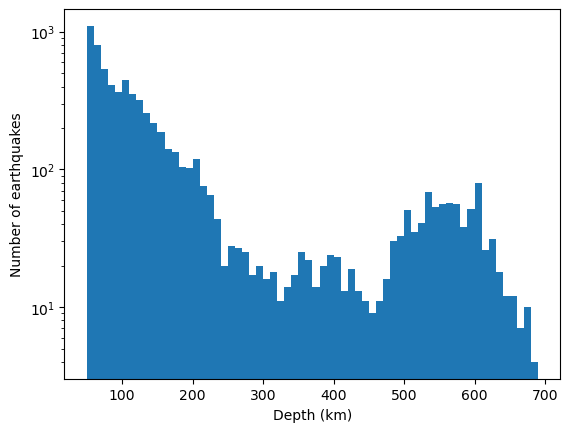

In [4]:
fig, ax = plt.subplots()
ax.hist(depth, bins=np.arange(50, 700, 10), log=True)
ax.set_xlabel("Depth (km)")
ax.set_ylabel("Number of earthquakes")
plt.show()

## 地震震级直方图

同理，从地震目录中提取出地震震级信息，保存到数组 `mag` 中并绘图。从图中可以明显看到，
震级越小地震数目越多：

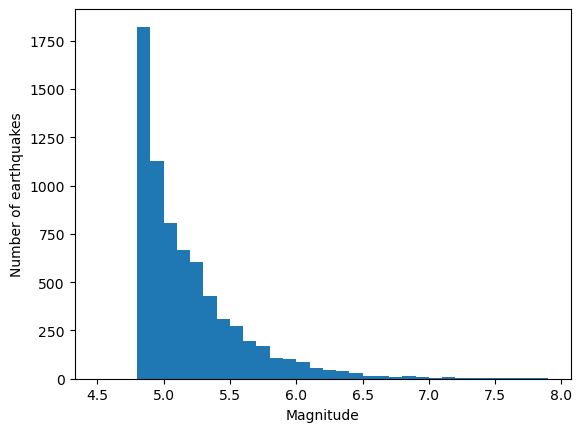

In [5]:
mag = np.array([event.magnitudes[0].mag for event in cat])

fig, ax = plt.subplots()
ax.hist(mag, bins=np.arange(4.5, 8, 0.1))
ax.set_xlabel("Magnitude")
ax.set_ylabel("Number of earthquakes")
plt.show()

## 地震震级-频度关系

地震震级-频度关系应符合 Gutenberg–Richter 定律。为了绘制地震震级-频度关系，
首先需要计算得到 GR 定律里的 $N$，即大于等于某个特定震级 $M$ 的地震数目。
这里，我们选择 $M$ 的取值范围为 4.0 到 8.0，间隔为 0.1。计算 $N$ 的方法有很多，下面的
方法使用了 Python 的列表表达式以及 {func}`numpy.sum()` 函数来实现：

In [6]:
mw = np.arange(4.0, 8.0, 0.1)
counts = np.array([(mag >= m).sum() for m in mw])

绘图脚本如下，注意图中 Y 轴是对数坐标。从图中可以明显看到 $\log_{10}N$ 与 $M$ 在 4.8 - 7.6 级
之间存在线性关系。由于我们使用的地震目录里只有 4.8 级以上的地震，所以在 4.7 级以下偏离了线性关系，而大地震由于数目太少也偏离了线性关系。

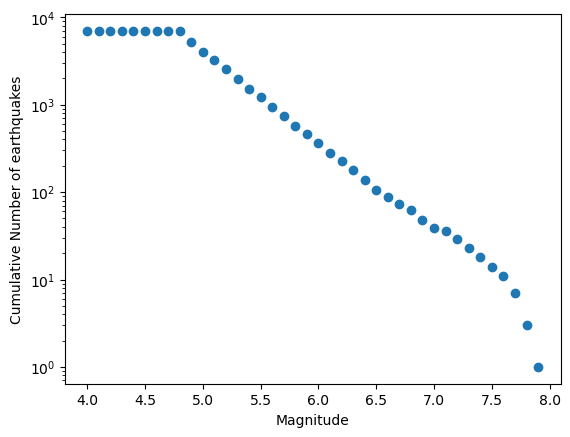

In [7]:
fig, ax = plt.subplots()
ax.semilogy(mw, counts, "o")
ax.set_xlabel("Magnitude")
ax.set_ylabel("Cumulative Number of earthquakes")
plt.show()

更进一步，我们可以对 4.8-7.6 级之间的数据进行线性拟合，得到 GR 定律中的系数 $a$ 和 $b$。
这里我们采用 {data}`numpy.logical_and` 函数找到数组 `mw` 中所有满足条件的元素的索引，
并使用 NumPy 的布尔索引功能筛选出满足条件的震级 `mw[idx]` 和对应的 `counts[idx]`，再
使用 {func}`numpy.polyfit` 函数拟合一元一次多项式，最后绘图：

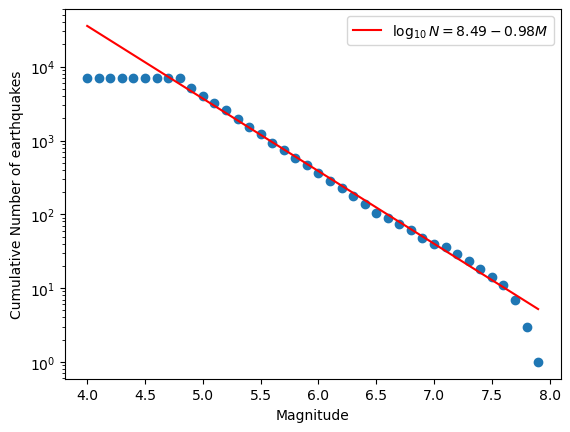

In [8]:
idx = np.logical_and(mw >= 4.8, mw <= 7.5)
# fitting y = p[0] * x + p[1]
p = np.polyfit(mw[idx], np.log10(counts[idx]), 1)
N_pred = 10 ** (mw * p[0] + p[1])

fig, ax = plt.subplots()
ax.semilogy(mw, counts, "o")
ax.semilogy(mw, N_pred, color="red", label=f"$\log_{{10}} N={p[1]:.2f}{p[0]:.2f}M$")
ax.legend()
ax.set_xlabel("Magnitude")
ax.set_ylabel("Cumulative Number of earthquakes")
plt.show()